<a href="https://colab.research.google.com/github/hunubul/Sirtet/blob/master/ANN_DANN_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.manifold import TSNE
import urllib
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops

In [0]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

#load mnist
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.float32) 
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.float32)
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_train = (mnist_train*2.0)-1.0
mnist_test = (mnist_test*2.0)-1.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
#load mnistm
# Load MNIST-M - this might take a while
#url="http://users.itk.ppke.hu/~horan/mnistm/mnistm_data.pkl"
#mnistm = pkl.load( open(urllib.request.urlopen(url).read()) )
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'), encoding='latin1')

mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

mnistm_train =(mnistm_train/128.0)-1.0
mnistm_test =(mnistm_test/128.0)-1.0
mnistm_valid =(mnistm_valid/128.0)-1.0


In [0]:
def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()


def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
        
class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient" +str(self.num_calls)
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * l]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
            
        self.num_calls += 1
        return y
flip_gradient = FlipGradientBuilder()

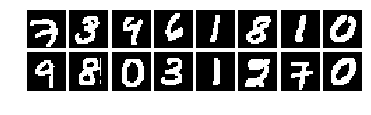

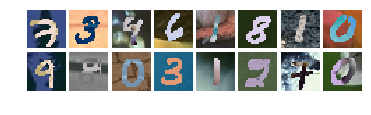

In [0]:
imshow_grid((mnist_train+1.0)/2.0)
imshow_grid((mnistm_train+1.0)/2.0)

In [0]:
batch_length = 64  # batches of 32 images are processed and averaged out
size = [28, 28, 3]  # the size of the image
num_classes = 10  # the number of possible output classes
learning_rate = 1e-3
info_freq = 100
eval_freq = 1000
num_kernels = [32,48]  # a list that defines the number of layers and convolutions for our network

In [0]:
tf.reset_default_graph()



input_data = tf.placeholder(tf.float32, [None] + size)  # input images
class_labels = tf.placeholder(tf.float32, [None, num_classes])  # labels, the expected outputs

current_input = input_data
current_filters = size[2]
layer_num = 0

# a loop to create all our layers
for num in num_kernels:
        with tf.variable_scope('featureext_' + str(layer_num)):
            layer_num += 1

            # variables we want to optimize
            w = tf.get_variable('w', [5, 5, current_filters, num])
            b = tf.get_variable('b', [num])
        
            # convolution
            conv_result = tf.nn.conv2d(current_input, w, strides=[1, 1, 1, 1], padding='VALID')
            current_filters = num
              
            conv_result = tf.add(conv_result, b)
            relu = tf.nn.relu(conv_result)

            # pooling
            pooled = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
            current_input = pooled
embedding=current_input
# we have generated feature maps; we will now use a fully connected layer with 10 neurons, one for each class
# the response of these neurons will represent how strongly the input belongs to the corresponding class
with tf.variable_scope('classifier'):
        current_shape = current_input.get_shape()
        feature_length = int(current_shape[1] * current_shape[2] * current_shape[3])
      
        fully_connected= current_input
        fully_connected = tf.reshape(fully_connected, [-1, feature_length])
        w = tf.get_variable('w', [feature_length, 100])
        fully_connected = tf.matmul(fully_connected, w)
        bias = tf.get_variable('bias', [100])
        fully_connected = tf.add(fully_connected, bias)
        fully_connected = tf.nn.relu(fully_connected)
        w = tf.get_variable('w2', [100, 100])
        fully_connected = tf.matmul(fully_connected, w)
        bias = tf.get_variable('bias2', [100])
        fully_connected = tf.add(fully_connected, bias)
        fully_connected = tf.nn.relu(fully_connected)
        w = tf.get_variable('w3', [100, num_classes])
        fully_connected = tf.matmul(fully_connected, w)
        bias = tf.get_variable('bias3', [num_classes])
        fully_connected = tf.add(fully_connected, bias)
        fully_connected = tf.nn.relu(fully_connected)



with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=class_labels, logits=fully_connected))
    


with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)    
    
with tf.name_scope('accuracy'):
        correct_predictions = tf.equal(tf.argmax(fully_connected, 1), tf.argmax(class_labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

      

In [0]:
init = tf.global_variables_initializer()  
with tf.Session() as sess:
  
   
    sess.run(init)

    step = 0
    print('\nStarting training...\n')

    #domain adversarial training    
    for step in range(1,10000):
      #train the classifier, to ensure it will not forget the classes
      
      selectedind= random.sample(range(mnist_train.shape[0]), int(batch_length))

      batch_xs = mnist_train[selectedind,:,:,:]
      batch_ys = mnist.train.labels[selectedind,:]
       
      _, acc, lo = sess.run([optimizer, accuracy, loss], feed_dict={input_data: batch_xs, class_labels: batch_ys})
      
      if step % info_freq == 0:
            print('Step: ' + str(step) + ' Loss: ' + str(lo) + ' Accuracy: ' + str(acc))
        
      if step % eval_freq == 0:
            sum_acc = 0.0
            it=0.0
            bl=32
            for i in range(0,mnist_test.shape[0]-bl,bl):
                selectedind= random.sample(range(mnist_test.shape[0]), int(batch_length))
                batch_xs =  mnist_test[selectedind,:,:,:]
                batch_ys = mnist.test.labels[selectedind,:]
                acc = sess.run(accuracy, feed_dict={input_data: batch_xs, class_labels: batch_ys})
                sum_acc += acc
                it+=1.0

            test_acc = sum_acc / it

            print('\nAccuracy on independent test set at step ' + str(step) + ': ' + str(test_acc) + '\n')      
            sum_acc = 0.0
            it=0.0
            bl=32
            for i in range(0,mnistm_test.shape[0]-bl,bl):
              selectedind= random.sample(range(mnistm_test.shape[0]), int(batch_length))                
              batch_xs = mnistm_test[selectedind,:,:,:]
              batch_ys = mnist.test.labels[selectedind,:]
         
              acc = sess.run(accuracy, feed_dict={input_data: batch_xs, class_labels: batch_ys})
              sum_acc += acc
              it+=1.0

            test_acc = sum_acc / it
            print('\nAccuracy on MNIST-M ' + str(step) + ': ' + str(test_acc) + '\n')
    
   


Starting training...

Step: 100 Loss: 0.8607104 Accuracy: 0.6875
Step: 200 Loss: 0.6910656 Accuracy: 0.71875
Step: 300 Loss: 0.7289516 Accuracy: 0.703125
Step: 400 Loss: 0.90511394 Accuracy: 0.671875
Step: 500 Loss: 0.79366195 Accuracy: 0.6875
Step: 600 Loss: 0.8529533 Accuracy: 0.671875
Step: 700 Loss: 0.8681923 Accuracy: 0.625
Step: 800 Loss: 0.555527 Accuracy: 0.765625
Step: 900 Loss: 0.66651577 Accuracy: 0.71875
Step: 1000 Loss: 0.7713793 Accuracy: 0.6875

Accuracy on independent test set at step 1000: 0.6973657852564102


Accuracy on MNIST-M 1000: 0.42467948717948717

Step: 1100 Loss: 0.97305006 Accuracy: 0.59375
Step: 1200 Loss: 0.7969902 Accuracy: 0.65625
Step: 1300 Loss: 0.5561876 Accuracy: 0.78125
Step: 1400 Loss: 0.60437274 Accuracy: 0.765625
Step: 1500 Loss: 0.952237 Accuracy: 0.59375
Step: 1600 Loss: 0.62360907 Accuracy: 0.734375
Step: 1700 Loss: 0.5301196 Accuracy: 0.78125
Step: 1800 Loss: 0.50080186 Accuracy: 0.796875
Step: 1900 Loss: 0.8464675 Accuracy: 0.65625
Step: 20

# New Section